# Distribution des partis politiques dans le temps 

Dans ce carnet est proposée une analyse de la distribution dans le temps des années de naissance de la population retenue, et la mise en évidence de générations.

On met aussi en évidence l'évolution dans le temps des partis politiques

In [1]:
### Librairie à installer dans l'environnement conda (si on exécute en local)
# qui sera choisi pour exécuter le carnet
from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

In [2]:
### Librairies déjà installées avec Python
import pprint
import csv
import sys

import sqlite3 as sql

import time
import datetime
from dateutil import parser

from importlib import reload
from shutil import copyfile


In [3]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf

## SPARQL Query qui récupère les données

On exécute la requête grâce à une fonction de la librairie locale qui réalise la mise en forme

In [4]:
## define SPARQL enpoint
endpoint = "https://ag1klf98suhepl85.allegrograph.cloud/repositories/Swiss_national_council"

In [5]:
query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>


SELECT  ?s (MAX(?label) as ?label) (xsd:integer(MAX(?birthDate)) as ?birthDate) (MAX(?politicalparty) as ?politicalparty)
WHERE {
    GRAPH <https://github.com/tbu02/swiss_national_council/blob/main/Graphiques/wikidata_imported_data.md>
        {?s wdt:P102 ?politicalparty;
            rdfs:label ?label;
            wdt:P569 ?birthDate.
          }
}
GROUP BY ?s
"""

In [6]:
### Executer la requête avec les fonctions de la librairie locale
qr = spqf.get_json_sparql_result(endpoint,query)

In [7]:
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

1648


[['http://www.wikidata.org/entity/Q1771134',
  'Markus Ritter',
  '1967',
  'http://www.wikidata.org/entity/Q100934025'],
 ['http://www.wikidata.org/entity/Q1673126',
  'Walter König',
  '1908',
  'http://www.wikidata.org/entity/Q303745'],
 ['http://www.wikidata.org/entity/Q1582102',
  'Hans Roth',
  '1913',
  'http://www.wikidata.org/entity/Q477228']]

In [8]:
### Créer un DataFrame à partir du résultat
df_p = pd.DataFrame(r)
df_p.columns = ['personUri', 'personLabel', 'birthYear', 'politicalpartyUri']
df_p.head()

,personUri,personLabel,birthYear,politicalpartyUri
0,http://www.wikidata.org/entity/Q1771134,Markus Ritter,1967,http://www.wikidata.org/entity/Q100934025
1,http://www.wikidata.org/entity/Q1673126,Walter König,1908,http://www.wikidata.org/entity/Q303745
2,http://www.wikidata.org/entity/Q1582102,Hans Roth,1913,http://www.wikidata.org/entity/Q477228
3,http://www.wikidata.org/entity/Q1065795,Charles Poncet,1946,http://www.wikidata.org/entity/Q667785
4,http://www.wikidata.org/entity/Q59843752,Guglielmo Canevascini,1886,http://www.wikidata.org/entity/Q303745


In [9]:
df_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1648 entries, 0 to 1647
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   personUri          1648 non-null   object
 1   personLabel        1648 non-null   object
 2   birthYear          1648 non-null   object
 3   politicalpartyUri  1648 non-null   object
dtypes: object(4)
memory usage: 51.6+ KB


### Vérifier les partis présents directement sur la base de données


Voir les requêtes correspondantes dans le [SPARQL notebook qui créé la population](../../sparqlbooks/wikidata_import_population.sparqlbook)

### Ajouter une colonne au DataFrame avec le code du parti politique 

In [90]:
### On créé d'abord une fonction qui effectue le travail

## l'argument de la fonction 'pp_uri' est un nom choisi librement
# il est ensuite appelé dans la fonction comme variable
# et contient la valeur introduite lors de l'utilisation de la fonction 
def code_politicalparty(pp_uri):
    if pp_uri == 'http://www.wikidata.org/entity/Q13850128':
        a = 'Parti radical-démocratique'
    elif pp_uri =='http://www.wikidata.org/entity/Q303745':
        a = 'Parti_socialiste_suisse'
    elif pp_uri =='http://www.wikidata.org/entity/Q659461':
        a = 'Parti_démocrate_chrétien'
    elif pp_uri =='http://www.wikidata.org/entity/Q385258':
        a = 'Union_démocratique_du_centre'
    elif pp_uri =='http://www.wikidata.org/entity/Q202638':
        a = 'Parti_libéral_radical'
    elif pp_uri =='http://www.wikidata.org/entity/Q667785':
        a = 'Parti libéral suisse'
    elif pp_uri =='http://www.wikidata.org/entity/Q100934025':
        a = 'Le_centre'
    elif pp_uri =='http://www.wikidata.org/entity/Q477228':
        a = 'Parti des paysans, artisans et indépendants'
    elif pp_uri =='http://www.wikidata.org/entity/Q667718':
        a = 'Parti évangélique suisse'
    elif pp_uri =='http://www.wikidata.org/entity/Q550295':
        a = 'Alliance des indépendants'
    elif pp_uri =='http://www.wikidata.org/entity/Q661771':
        a = 'Parti suisse du travail'
    elif pp_uri =='http://www.wikidata.org/entity/Q681843':
        a = 'Parti démocratique suisse'
    elif pp_uri =='http://www.wikidata.org/entity/Q151768':
        a = 'Parti bourgeois démocratique'
    elif pp_uri =='http://www.wikidata.org/entity/Q667836':
        a = 'Union démocratique fédérale'
    elif pp_uri =='http://www.wikidata.org/entity/Q659739':
        a = 'Les_Verts'
    elif pp_uri =='http://www.wikidata.org/entity/Q545900': 
        a = 'Vertlibéraux'
    else:
        a = 'Autres'
    return a    

In [91]:
### On teste la fonction
print(code_politicalparty('http://www.wikidata.org/entity/Q303745'))

Parti_socialiste_suisse


In [92]:
### On ajoute une nouvelle colonne et y on met pour chaque ligne le résultat de la fonction
df_p['ppCode'] = df_p.apply(lambda x: code_politicalparty(x['politicalpartyUri']), axis=1)

In [93]:
### On inspecte les cinq premières lignes qui ont la valeur 'A' = autre
df_p[df_p['ppCode']=='Autres'][:5]

,personUri,personLabel,birthYear,politicalpartyUri,ppCode
15,http://www.wikidata.org/entity/Q125702,Hugo Fasel,1955,http://www.wikidata.org/entity/Q667725,Autres
25,http://www.wikidata.org/entity/Q1782235,Konrad Müller,1892,http://www.wikidata.org/entity/Q1084147,Autres
37,http://www.wikidata.org/entity/Q15436200,Friedrich Fritschi,1851,http://www.wikidata.org/entity/Q674695,Autres
80,http://www.wikidata.org/entity/Q120924,Werner Carobbio,1936,http://www.wikidata.org/entity/Q3366732,Autres
108,http://www.wikidata.org/entity/Q72063373,Stéfanie Prezioso,1969,http://www.wikidata.org/entity/Q20012603,Autres


## Effectifs par année

In [94]:
### On inspecte les valeurs de la colonne 'birthYear' 
# et on observe que le type de données est 'object', ici texte
df_p['birthYear'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1648 entries, 0 to 1647
Series name: birthYear
Non-Null Count  Dtype
--------------  -----
1648 non-null   int64
dtypes: int64(1)
memory usage: 13.0 KB


In [95]:
### On transforme le type de valeur de la colonne BirthYear
# de objet à entier
df_p['birthYear'] = df_p['birthYear'].astype(int)

In [96]:
### On transforme en DataFrame le résultat du regroupement par année
# noter qu'un ajoute un filtre pour que l'année maximale de naissance soit 200
years_count = pd.DataFrame(df_p[df_p['birthYear'] < 2001].groupby('birthYear').size())\
                .reset_index(drop=False)
years_count.columns=['year','effectif']
years_count

,year,effectif
0,1794,1
1,1796,1
2,1800,3
3,1801,3
4,1802,1
...,...,...
189,1990,4
190,1991,3
191,1992,3
192,1994,2


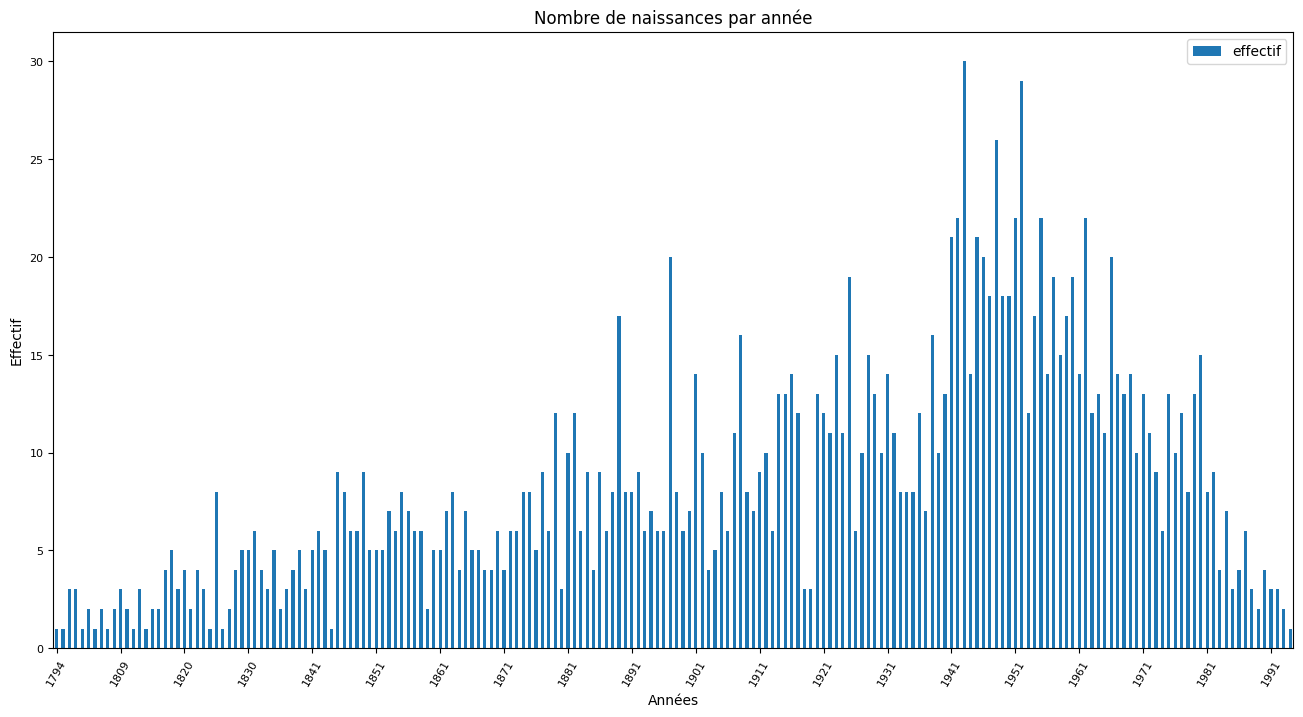

In [97]:
### Représentation graphique des effectifs par année

ax = years_count.plot(x='year', y='effectif', kind='bar',rot=60, fontsize=8, figsize=(16,8))


max_xticks = 20
xloc = plt.MaxNLocator(max_xticks)
ax.xaxis.set_major_locator(xloc)

plt.ylabel('Effectif')
plt.xlabel('Années')
plt.title('Nombre de naissances par année')

plt.show()

## Regrouper les effectifs par périodes de 20 ans

In [98]:
### Créer une copie indépendante du DataFrame (attention aux copies de variables qui sont seulement des alias) 
cdf_p = df_p[df_p['birthYear'] < 2001].copy(deep=True)

In [99]:
cdf_p.head(3)

,personUri,personLabel,birthYear,politicalpartyUri,ppCode
0,http://www.wikidata.org/entity/Q1771134,Markus Ritter,1967,http://www.wikidata.org/entity/Q100934025,Le_centre
1,http://www.wikidata.org/entity/Q1673126,Walter König,1908,http://www.wikidata.org/entity/Q303745,Parti_socialiste_suisse
2,http://www.wikidata.org/entity/Q1582102,Hans Roth,1913,http://www.wikidata.org/entity/Q477228,"Parti des paysans, artisans et indépendants"


In [100]:
### Année minimale et maximale dans la population
print(min(cdf_p['birthYear']), max(cdf_p['birthYear']))

1794 1996


### Codage par période de vingt ans

In [101]:
### Créer une liste d'années pour séparer en périodes de 20 ans
# noter que la dernière année sera exclue, 
# elle donc doit être supérieure à la valeur maximale 
l_25 = list(range(1781, 2020, 20))
print(l_25[:5],l_25[-5:])

[1781, 1801, 1821, 1841, 1861] [1921, 1941, 1961, 1981, 2001]


In [102]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

cdf_p['periodes'] = pd.cut(cdf_p['birthYear'], l_25, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
cdf_p['periodes'] = cdf_p['periodes'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
cdf_p.head(5)

,personUri,personLabel,birthYear,politicalpartyUri,ppCode,periodes
0,http://www.wikidata.org/entity/Q1771134,Markus Ritter,1967,http://www.wikidata.org/entity/Q100934025,Le_centre,1961-1980
1,http://www.wikidata.org/entity/Q1673126,Walter König,1908,http://www.wikidata.org/entity/Q303745,Parti_socialiste_suisse,1901-1920
2,http://www.wikidata.org/entity/Q1582102,Hans Roth,1913,http://www.wikidata.org/entity/Q477228,"Parti des paysans, artisans et indépendants",1901-1920
3,http://www.wikidata.org/entity/Q1065795,Charles Poncet,1946,http://www.wikidata.org/entity/Q667785,Parti libéral suisse,1941-1960
4,http://www.wikidata.org/entity/Q59843752,Guglielmo Canevascini,1886,http://www.wikidata.org/entity/Q303745,Parti_socialiste_suisse,1881-1900


In [103]:
### compter les naissances par périodes de 20 ans
cdf_p.groupby(by='periodes',observed=False).size()

periodes
1781-1800      5
1801-1820     42
1821-1840     70
1841-1860    117
1861-1880    122
1881-1900    172
1901-1920    185
1921-1940    229
1941-1960    394
1961-1980    253
1981-2000     59
dtype: int64

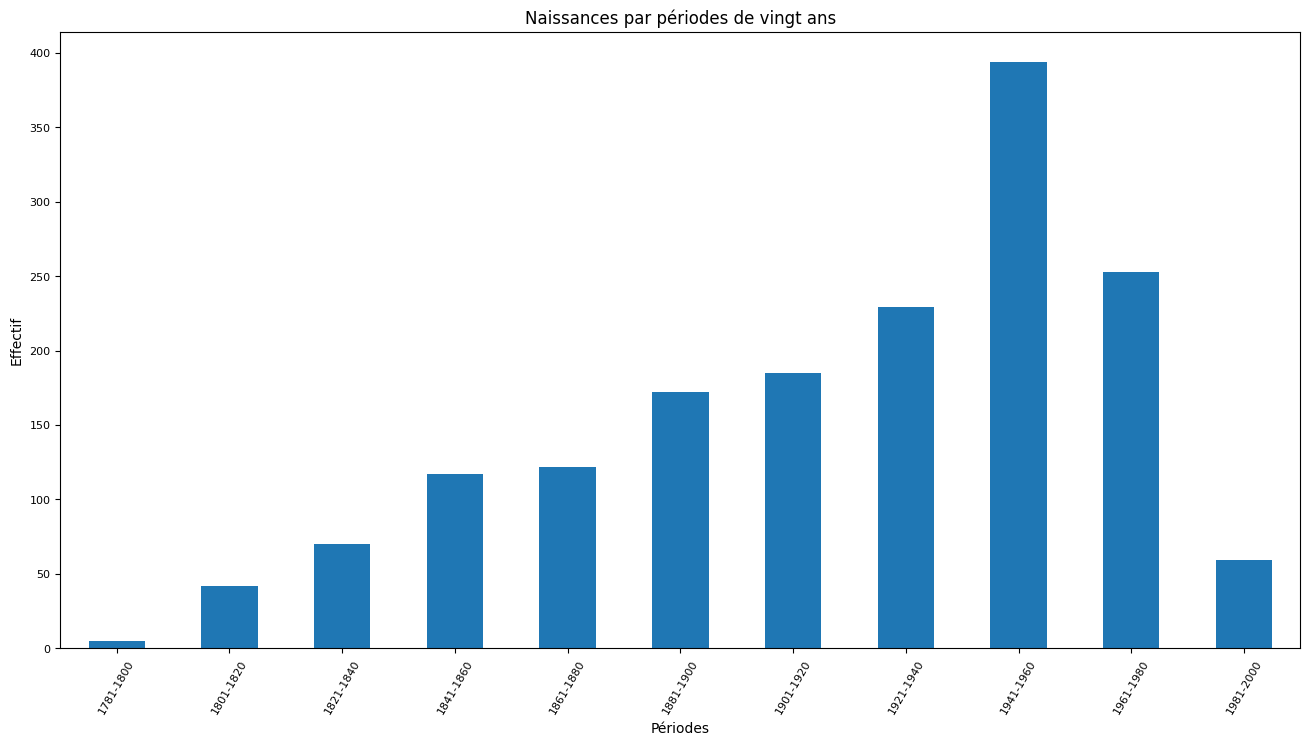

In [104]:
ax = cdf_p.groupby(by='periodes', observed=False).size().plot(kind='bar',rot=60, fontsize=8, figsize=(16,8))
plt.ylabel('Effectif')
plt.xlabel('Périodes')
plt.title('Naissances par périodes de vingt ans')
plt.show()

## Ajouter la représentation des partis politiques

In [105]:
### Regrouper et compter avec un fitre sur le parti radical-démocratique
pp_prd = pd.DataFrame(cdf_p[cdf_p.ppCode == 'Parti radical-démocratique'].groupby('periodes',observed=False).size())
pp_prd.columns = ['Parti radical-démocratique']
pp_prd.tail()


,Parti radical-démocratique
periodes,
1901-1920,55
1921-1940,61
1941-1960,44
1961-1980,3
1981-2000,0


In [106]:
### Regrouper et compter avec un fitre sur le parti socialiste suisse
pp_pss = pd.DataFrame(cdf_p[cdf_p.ppCode == 'Parti_socialiste_suisse'].groupby('periodes',observed=False).size())
pp_pss.columns = ['Parti_socialiste_suisse']
pp_pss.tail()


,Parti_socialiste_suisse
periodes,
1901-1920,43
1921-1940,50
1941-1960,95
1961-1980,47
1981-2000,22


In [107]:
### Regrouper et compter avec un fitre sur le parti socialiste suisse
pp_pdc = pd.DataFrame(cdf_p[cdf_p.ppCode == 'Parti_démocrate_chrétien'].groupby('periodes',observed=False).size())
pp_pdc.columns = ['Parti_démocrate_chrétien']
pp_pdc.tail()


,Parti_démocrate_chrétien
periodes,
1901-1920,32
1921-1940,49
1941-1960,61
1961-1980,22
1981-2000,4


In [108]:
### Regrouper et compter avec un fitre sur le parti socialiste suisse
pp_udc = pd.DataFrame(cdf_p[cdf_p.ppCode == 'Union_démocratique_du_centre'].groupby('periodes',observed=False).size())
pp_udc.columns = ['Union_démocratique_du_centre']
pp_udc.tail()


,Union_démocratique_du_centre
periodes,
1901-1920,2
1921-1940,27
1941-1960,67
1961-1980,70
1981-2000,16


In [109]:
### Regrouper et compter avec un fitre sur le parti socialiste suisse
pp_plr = pd.DataFrame(cdf_p[cdf_p.ppCode == 'Parti_libéral_radical'].groupby('periodes',observed=False).size())
pp_plr.columns = ['Parti_libéral_radical']
pp_plr.tail()


,Parti_libéral_radical
periodes,
1901-1920,1
1921-1940,0
1941-1960,25
1961-1980,35
1981-2000,4


In [110]:
### Regrouper et compter avec un fitre sur le parti socialiste suisse
pp_pls = pd.DataFrame(cdf_p[cdf_p.ppCode == 'Parti libéral suisse'].groupby('periodes',observed=False).size())
pp_pls.columns = ['Parti libéral suisse']
pp_pls.tail()


,Parti libéral suisse
periodes,
1901-1920,9
1921-1940,12
1941-1960,12
1961-1980,1
1981-2000,0


In [111]:
### Regrouper et compter avec un fitre sur le parti socialiste suisse
pp_LC = pd.DataFrame(cdf_p[cdf_p.ppCode == 'Le_centre'].groupby('periodes',observed=False).size())
pp_LC.columns = ['Le_centre']
pp_LC.tail()


,Le_centre
periodes,
1901-1920,0
1921-1940,0
1941-1960,5
1961-1980,18
1981-2000,1


In [112]:
### Regrouper et compter avec un fitre sur le parti socialiste suisse
pp_ppai = pd.DataFrame(cdf_p[cdf_p.ppCode == 'Parti des paysans, artisans et indépendants'].groupby('periodes',observed=False).size())
pp_ppai.columns = ['Parti des paysans, artisans et indépendants']
pp_ppai.tail()


,"Parti des paysans, artisans et indépendants"
periodes,
1901-1920,11
1921-1940,3
1941-1960,0
1961-1980,0
1981-2000,0


In [113]:
### Regrouper et compter avec un fitre sur le parti socialiste suisse
pp_pev = pd.DataFrame(cdf_p[cdf_p.ppCode == 'Parti évangélique suisse'].groupby('periodes',observed=False).size())
pp_pev.columns = ['Parti évangélique suisse']
pp_pev.tail()


,Parti évangélique suisse
periodes,
1901-1920,2
1921-1940,2
1941-1960,5
1961-1980,3
1981-2000,0


In [114]:
### Regrouper et compter avec un fitre sur le parti socialiste suisse
pp_all = pd.DataFrame(cdf_p[cdf_p.ppCode == 'Alliance des indépendants'].groupby('periodes',observed=False).size())
pp_all.columns = ['Alliance des indépendants']
pp_all.tail()


,Alliance des indépendants
periodes,
1901-1920,15
1921-1940,7
1941-1960,6
1961-1980,1
1981-2000,0


In [115]:
### Regrouper et compter avec un fitre sur le parti socialiste suisse
pp_pop = pd.DataFrame(cdf_p[cdf_p.ppCode == 'Parti suisse du travail'].groupby('periodes',observed=False).size())
pp_pop.columns = ['Parti suisse du travail']
pp_pop.tail()


,Parti suisse du travail
periodes,
1901-1920,4
1921-1940,1
1941-1960,4
1961-1980,0
1981-2000,0


In [116]:
### Regrouper et compter avec un fitre sur le parti socialiste suisse
pp_pds = pd.DataFrame(cdf_p[cdf_p.ppCode == 'Parti démocratique suisse'].groupby('periodes',observed=False).size())
pp_pds.columns = ['Parti démocratique suisse']
pp_pds.tail()


,Parti démocratique suisse
periodes,
1901-1920,3
1921-1940,1
1941-1960,0
1961-1980,0
1981-2000,0


In [117]:
### Regrouper et compter avec un fitre sur le parti socialiste suisse
pp_pbd = pd.DataFrame(cdf_p[cdf_p.ppCode == 'Parti bourgeois démocratique'].groupby('periodes',observed=False).size())
pp_pbd.columns = ['Parti bourgeois démocratique']
pp_pbd.tail()

,Parti bourgeois démocratique
periodes,
1901-1920,0
1921-1940,1
1941-1960,9
1961-1980,3
1981-2000,0


In [118]:
### Regrouper et compter avec un fitre sur le parti socialiste suisse
pp_udf = pd.DataFrame(cdf_p[cdf_p.ppCode == 'Union démocratique fédérale'].groupby('periodes',observed=False).size())
pp_udf.columns = ['Union démocratique fédérale']
pp_udf.tail()

,Union démocratique fédérale
periodes,
1901-1920,0
1921-1940,0
1941-1960,4
1961-1980,1
1981-2000,0


In [119]:
### Regrouper et compter avec un fitre sur le parti socialiste suisse
pp_v = pd.DataFrame(cdf_p[cdf_p.ppCode == 'Les_Verts'].groupby('periodes',observed=False).size())
pp_v.columns = ['Les_Verts']
pp_v.tail()

,Les_Verts
periodes,
1901-1920,0
1921-1940,7
1941-1960,37
1961-1980,24
1981-2000,10


In [120]:
### Regrouper et compter avec un fitre sur le parti socialiste suisse
pp_vl = pd.DataFrame(cdf_p[cdf_p.ppCode == 'Vertlibéraux'].groupby('periodes',observed=False).size())
pp_vl.columns = ['Vertlibéraux']
pp_vl.tail()

,Vertlibéraux
periodes,
1901-1920,0
1921-1940,0
1941-1960,3
1961-1980,19
1981-2000,2


In [121]:
### Fusionner les deux tableaux en utilisant l'index comme clé de jointure
from functools import reduce

dfs = [pp_prd, pp_pss, pp_pdc, pp_udc, pp_plr, pp_pls, pp_LC,
       pp_ppai, pp_pev, pp_all, pp_pop, pp_pds, pp_pbd, pp_udf,
       pp_v, pp_vl]

merged = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True), dfs)

In [122]:
### Transformer l'index de séquence à chaîne de caractères
# ce qui est indispensable pour l'affichage dans un graphique
merged.index = merged.index.map(str)
merged.tail()

,Parti radical-démocratique,Parti_socialiste_suisse,Parti_démocrate_chrétien,Union_démocratique_du_centre,Parti_libéral_radical,Parti libéral suisse,Le_centre,"Parti des paysans, artisans et indépendants",Parti évangélique suisse,Alliance des indépendants,Parti suisse du travail,Parti démocratique suisse,Parti bourgeois démocratique,Union démocratique fédérale,Les_Verts,Vertlibéraux
periodes,,,,,,,,,,,,,,,,
1901-1920,55,43,32,2,1,9,0,11,2,15,4,3,0,0,0,0
1921-1940,61,50,49,27,0,12,0,3,2,7,1,1,1,0,7,0
1941-1960,44,95,61,67,25,12,5,0,5,6,4,0,9,4,37,3
1961-1980,3,47,22,70,35,1,18,0,3,1,0,0,3,1,24,19
1981-2000,0,22,4,16,4,0,1,0,0,0,0,0,0,0,10,2


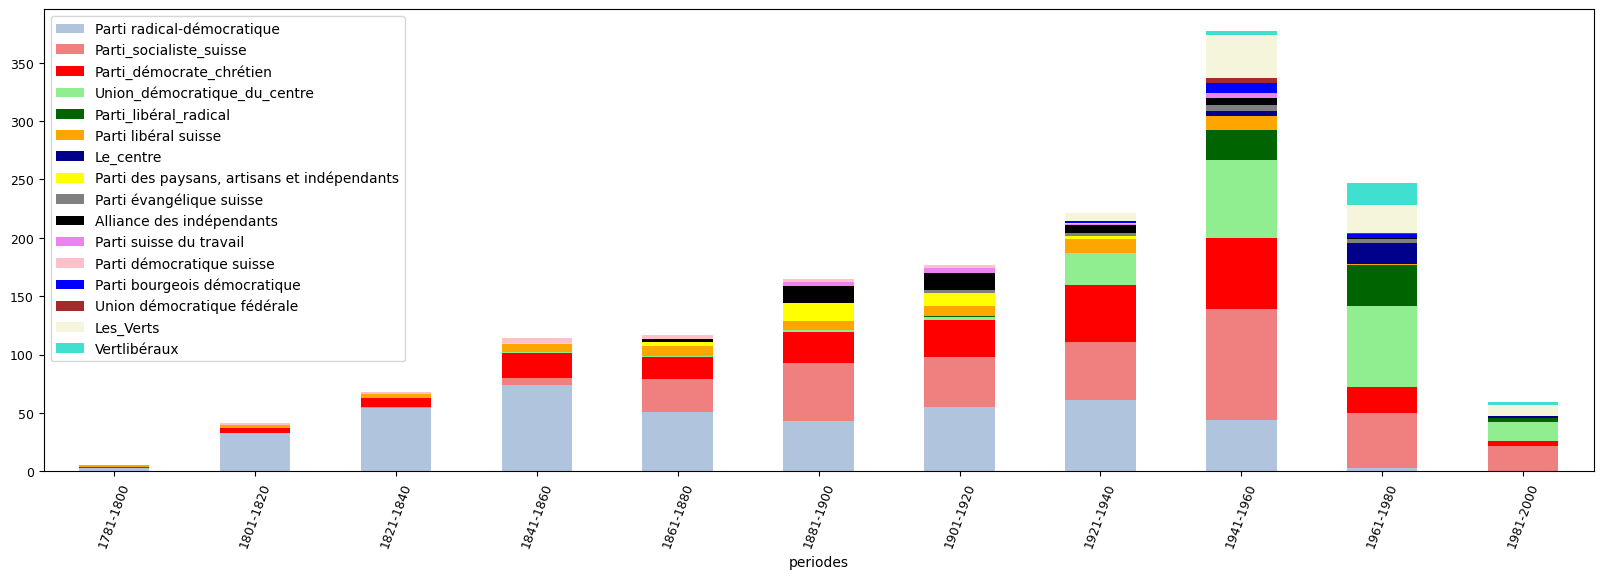

In [123]:
### Documentation
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html
ax = merged.plot.bar(stacked=True, rot=70, fontsize=9, figsize=(20,6), color=['LightSteelBlue', 'LightCoral', 'red', 'Lightgreen', 'Darkgreen', 'orange', 'darkblue', 'yellow', 'grey', 'black', 'violet', 'pink', 'blue', 'brown', 'beige','turquoise'])
plt.savefig('Images/naissance_parti_20ans.png')
plt.show()

## Codage
Comme on peut le constater, il y a eu beaucoup d'évolution en plus de 240 ans. Pour y voir plus clairement, on divise les période en tranche de 10 ans, et ce à partir de 1941 pour avoir l'histoire récente. De plus, on ne retient pas les 15 partis les plus cités, mais les 5 partis principaux de Suisse, à savoir, Les Verts, le PS, Le Centre (et le PDC, son ancêtre), le PLR et l'UDC

In [124]:
l_10 = list(range(1941, 2010, 10))
print(l_10[:5],l_10[-5:])

[1941, 1951, 1961, 1971, 1981] [1961, 1971, 1981, 1991, 2001]


In [125]:
### Découpage par décennies
## fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html

cdf_p['per_10'] = pd.cut(cdf_p['birthYear'], l_10, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
cdf_p['per_10'] = cdf_p['per_10'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
cdf_p.head(3)

,personUri,personLabel,birthYear,politicalpartyUri,ppCode,periodes,per_10
0,http://www.wikidata.org/entity/Q1771134,Markus Ritter,1967,http://www.wikidata.org/entity/Q100934025,Le_centre,1961-1980,1961-1970
1,http://www.wikidata.org/entity/Q1673126,Walter König,1908,http://www.wikidata.org/entity/Q303745,Parti_socialiste_suisse,1901-1920,NaN
2,http://www.wikidata.org/entity/Q1582102,Hans Roth,1913,http://www.wikidata.org/entity/Q477228,"Parti des paysans, artisans et indépendants",1901-1920,NaN


In [126]:
### On regroupe par parti comme ci-dessus
pp_v_10 = pd.DataFrame(cdf_p[(cdf_p.ppCode == 'Les_Verts') & (cdf_p.birthYear > 1850)].groupby('per_10', observed=False).size())
pp_v_10.columns = ['Les_Verts']
pp_v_10.tail()


,Les_Verts
per_10,
1951-1960,20
1961-1970,9
1971-1980,15
1981-1990,8
1991-2000,2


In [127]:
### Idem
pp_pss_10 = pd.DataFrame(cdf_p[(cdf_p.ppCode == 'Parti_socialiste_suisse') & (cdf_p.birthYear > 1850)].groupby('per_10', observed=False).size())
pp_pss_10.columns = ['Parti_socialiste_suisse']
pp_pss_10.tail()


,Parti_socialiste_suisse
per_10,
1951-1960,49
1961-1970,26
1971-1980,21
1981-1990,20
1991-2000,2


In [128]:
### Idem
pp_LC_10 = pd.DataFrame(cdf_p[(cdf_p.ppCode == 'Le_centre') & (cdf_p.birthYear > 1850)].groupby('per_10', observed=False).size())
pp_LC_10.columns = ['Le_centre']
pp_LC_10.tail()


,Le_centre
per_10,
1951-1960,5
1961-1970,12
1971-1980,6
1981-1990,1
1991-2000,0


In [129]:
### Idem
pp_pdc_10 = pd.DataFrame(cdf_p[(cdf_p.ppCode == 'Parti_démocrate_chrétien') & (cdf_p.birthYear > 1850)].groupby('per_10', observed=False).size())
pp_pdc_10.columns = ['Parti_démocrate_chrétien']
pp_pdc_10.tail()


,Parti_démocrate_chrétien
per_10,
1951-1960,23
1961-1970,15
1971-1980,7
1981-1990,4
1991-2000,0


In [130]:
### Idem
pp_plr_10 = pd.DataFrame(cdf_p[(cdf_p.ppCode == 'Parti_libéral_radical') & (cdf_p.birthYear > 1850)].groupby('per_10', observed=False).size())
pp_plr_10.columns = ['Parti_libéral_radical']
pp_plr_10.tail()


,Parti_libéral_radical
per_10,
1951-1960,21
1961-1970,23
1971-1980,12
1981-1990,3
1991-2000,1


In [131]:
### Idem
pp_udc_10 = pd.DataFrame(cdf_p[(cdf_p.ppCode == 'Union_démocratique_du_centre') & (cdf_p.birthYear > 1850)].groupby('per_10', observed=False).size())
pp_udc_10.columns = ['Union_démocratique_du_centre']
pp_udc_10.tail()


,Union_démocratique_du_centre
per_10,
1951-1960,32
1961-1970,37
1971-1980,33
1981-1990,13
1991-2000,3


In [132]:
merged_10 = pp_v_10.merge(pp_pss_10, left_index=True, right_index=True)\
                   .merge(pp_LC_10, left_index=True, right_index=True)\
                   .merge(pp_pdc_10, left_index=True, right_index=True)\
                   .merge(pp_plr_10, left_index=True, right_index=True)\
                   .merge(pp_udc_10, left_index=True, right_index=True)
merged_10.tail()

,Les_Verts,Parti_socialiste_suisse,Le_centre,Parti_démocrate_chrétien,Parti_libéral_radical,Union_démocratique_du_centre
per_10,,,,,,
1951-1960,20,49,5,23,21,32
1961-1970,9,26,12,15,23,37
1971-1980,15,21,6,7,12,33
1981-1990,8,20,1,4,3,13
1991-2000,2,2,0,0,1,3


In [133]:
### On transforme le type de valeur de l'index
# et on ajoute une colonne avec le total
merged_10.index = merged_10.index.map(str)
merged_10['tot']=merged_10['Les_Verts']+merged_10['Parti_socialiste_suisse']+merged_10['Le_centre']+merged_10['Parti_démocrate_chrétien']+merged_10['Parti_libéral_radical']+merged_10['Union_démocratique_du_centre']
merged_10.tail()

,Les_Verts,Parti_socialiste_suisse,Le_centre,Parti_démocrate_chrétien,Parti_libéral_radical,Union_démocratique_du_centre,tot
per_10,,,,,,,
1951-1960,20,49,5,23,21,32,150
1961-1970,9,26,12,15,23,37,122
1971-1980,15,21,6,7,12,33,94
1981-1990,8,20,1,4,3,13,49
1991-2000,2,2,0,0,1,3,8


In [135]:
### On prépare les valeurs pour l'affichage des fréquences (proportion par rapport au total)

# liste qui contient toutes les valeurs à la suite
m_f = merged_10.Les_Verts.to_list()+merged_10.Parti_socialiste_suisse.to_list()+merged_10.Le_centre.to_list()+merged_10.Parti_démocrate_chrétien.to_list()+merged_10.Parti_libéral_radical.to_list()+merged_10.Union_démocratique_du_centre.to_list()

# liste d'égale longueur que la précédente qui contient 
# les valeurs de l'index, i.e. les périodes
tot = merged_10.tot.to_list()*6

# liste qui contient les valeurs des fréquences
lp = [round(v/t, 2) for v,t in zip(m_f, tot)]
lp[:3]

[0.12, 0.13, 0.07]

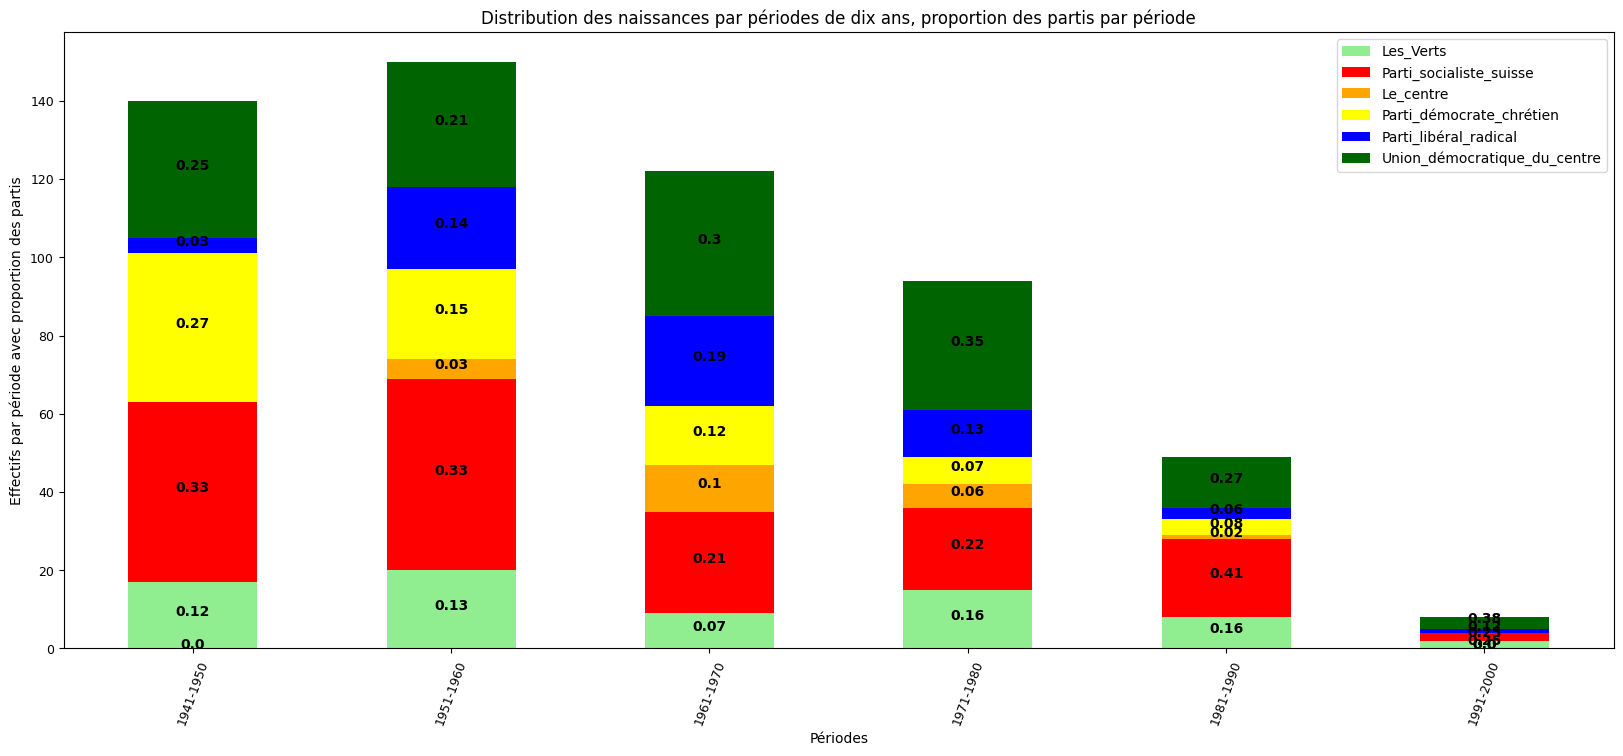

In [139]:
### Graphique avec la distribution par période et genre (M,F)
# Noter que les effectifs du genre 'Autres' étant très faibles,
# on ne les analyse pas de manière sérielle mais on peut les analyser qualitatiement

ax = merged_10.plot.bar(stacked=True, y=['Les_Verts', 'Parti_socialiste_suisse', 'Le_centre', 'Parti_démocrate_chrétien', 'Parti_libéral_radical', 'Union_démocratique_du_centre'], \
                        rot=70, fontsize=9, figsize=(20,8), color=['LightGreen', 'Red', 'Orange', 'Yellow', 'Blue', 'DarkGreen'])


### https://www.pythoncharts.com/matplotlib/stacked-bar-charts-labels/


## On ajoute une étiquette concernant la valeur de fréquence
# à chaque rectangle dans le graphe, en utilisant la list 'lp' préparée précédemment
# Il y a autant de triangles que les valeurs d'index x le nombre de variables

for bar,v in zip(ax.patches,lp): 

    ax.text(
      # Met les étiquette aux centre des rectangles
      bar.get_x() + bar.get_width() / 2,
        
      # Ajoute les coordonnées verticales
      bar.get_height()/2 + bar.get_y(), 
      
      # Ajoute les valeurs
      v,

      # centre et met du style aux étiquettes
      ha='center',
      color='black',
      weight='bold',
      size=10
  )

plt.ylabel('Effectifs par période avec proportion des partis')
plt.xlabel('Périodes')
plt.title('Distribution des naissances par périodes de dix ans, proportion des partis par période')

## On peut enregistrer l'image dans un fichier (noter le dossier créé préalablement)
# qu'on pourra ensuite introduire dans un travail et commenter

# Doc.: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html
plt.savefig('Images/naissances_distribution_10ans_partis.jpg', bbox_inches='tight',
                       pad_inches=0.2)
plt.show()

### PS vs UDC

In [143]:
### On regroupe par parti comme ci-dessus
pp_pss_vs_udc = pd.DataFrame(cdf_p[(cdf_p.ppCode == 'Parti_socialiste_suisse') & (cdf_p.birthYear > 1850)].groupby('per_10', observed=False).size())
pp_pss_vs_udc.columns = ['Parti_socialiste_suisse']
pp_pss_vs_udc.tail()

,Parti_socialiste_suisse
per_10,
1951-1960,49
1961-1970,26
1971-1980,21
1981-1990,20
1991-2000,2


In [144]:
### On regroupe par parti comme ci-dessus
pp_udc_vs_pss = pd.DataFrame(cdf_p[(cdf_p.ppCode == 'Union_démocratique_du_centre') & (cdf_p.birthYear > 1850)].groupby('per_10', observed=False).size())
pp_udc_vs_pss.columns = ['Union_démocratique_du_centre']
pp_udc_vs_pss.tail()

,Union_démocratique_du_centre
per_10,
1951-1960,32
1961-1970,37
1971-1980,33
1981-1990,13
1991-2000,3


In [145]:
merged_10 = pd.merge(pp_pss_vs_udc, pp_udc_vs_pss, left_index=True, right_index=True)
merged_10.tail()

,Parti_socialiste_suisse,Union_démocratique_du_centre
per_10,,
1951-1960,49,32
1961-1970,26,37
1971-1980,21,33
1981-1990,20,13
1991-2000,2,3


In [146]:
### On transforme le type de valeur de l'index
# et on ajoute une colonne avec le total
merged_10.index = merged_10.index.map(str)
merged_10['tot']=merged_10['Parti_socialiste_suisse']+merged_10['Union_démocratique_du_centre']
merged_10.tail()

,Parti_socialiste_suisse,Union_démocratique_du_centre,tot
per_10,,,
1951-1960,49,32,81
1961-1970,26,37,63
1971-1980,21,33,54
1981-1990,20,13,33
1991-2000,2,3,5


In [147]:
### On prépare les valeurs pour l'affichage des fréquences (proportion par rapport au total)

# liste qui contient toutes les valeurs à la suite
m_f = merged_10.Parti_socialiste_suisse.to_list()+merged_10.Union_démocratique_du_centre.to_list()

# liste d'égale longueur que la précédente qui contient 
# les valeurs de l'index, i.e. les périodes
tot = merged_10.tot.to_list()*2

# liste qui contient les valeurs des fréquences
lp = [round(v/t, 2) for v,t in zip(m_f, tot)]
lp[:3]

[0.57, 0.6, 0.41]

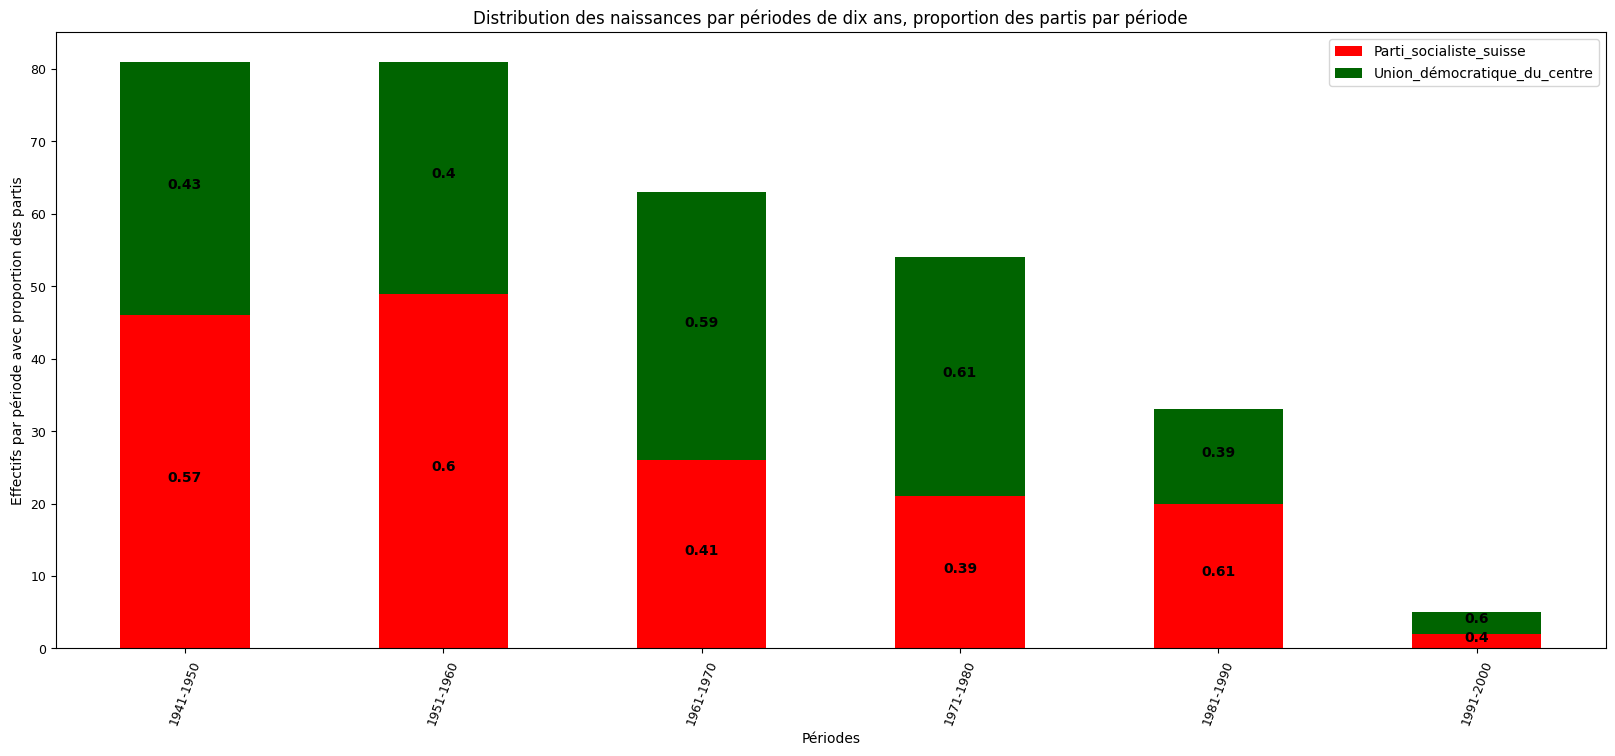

In [148]:
### Graphique avec la distribution par période et genre (M,F)
# Noter que les effectifs du genre 'Autres' étant très faibles,
# on ne les analyse pas de manière sérielle mais on peut les analyser qualitatiement

ax = merged_10.plot.bar(stacked=True, y=[ 'Parti_socialiste_suisse', 'Union_démocratique_du_centre'], \
                        rot=70, fontsize=9, figsize=(20,8), color=['Red', 'DarkGreen'])


### https://www.pythoncharts.com/matplotlib/stacked-bar-charts-labels/


## On ajoute une étiquette concernant la valeur de fréquence
# à chaque rectangle dans le graphe, en utilisant la list 'lp' préparée précédemment
# Il y a autant de triangles que les valeurs d'index x le nombre de variables

for bar,v in zip(ax.patches,lp): 

    ax.text(
      # Met les étiquette aux centre des rectangles
      bar.get_x() + bar.get_width() / 2,
        
      # Ajoute les coordonnées verticales
      bar.get_height()/2 + bar.get_y(), 
      
      # Ajoute les valeurs
      v,

      # centre et met du style aux étiquettes
      ha='center',
      color='black',
      weight='bold',
      size=10
  )

plt.ylabel('Effectifs par période avec proportion des partis')
plt.xlabel('Périodes')
plt.title('Distribution des naissances par périodes de dix ans, proportion des partis par période')

## On peut enregistrer l'image dans un fichier (noter le dossier créé préalablement)
# qu'on pourra ensuite introduire dans un travail et commenter

# Doc.: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html
plt.savefig('Images/naissances_distribution_10ans_partis_PSvsUDC.jpg', bbox_inches='tight',
                       pad_inches=0.2)
plt.show()